In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Create a Spark session
spark = SparkSession.builder.appName("Penguins Species Cluster Analysis").getOrCreate()

df = spark.read.csv("data/penguins_size.csv", header=True, inferSchema=True)
print(f'Initial DataFrame size: {df.count()} rows')

# Drop rows with NA strings and cast safely
df_clean = df.filter((col("culmen_length_mm").isNotNull()) & 
                     (col("culmen_depth_mm").isNotNull()) &
                     (col("culmen_length_mm") != "NA") &
                     (col("culmen_depth_mm") != "NA")) \
	.withColumn("culmen_length_mm", col("culmen_length_mm").cast("double")) \
	.withColumn("culmen_depth_mm", col("culmen_depth_mm").cast("double"))
df_clean = df_clean.filter(col("culmen_length_mm").isNotNull() & col("culmen_depth_mm").isNotNull())
# df_clean.cache()
print(f'Cleaned DataFrame size: {df_clean.count()} rows')
df.createOrReplaceTempView("penguins")

Initial DataFrame size: 344 rows
Cleaned DataFrame size: 342 rows


25/05/16 13:10:50 WARN CacheManager: Asked to cache already cached data.



Cluster centroids:
Cluster 0: [50.86511628 17.34767442]
Cluster 1: [38.4035461  18.27943262]
Cluster 2: [45.49565217 15.62086957]

Silhouette coefficient: 0.6711


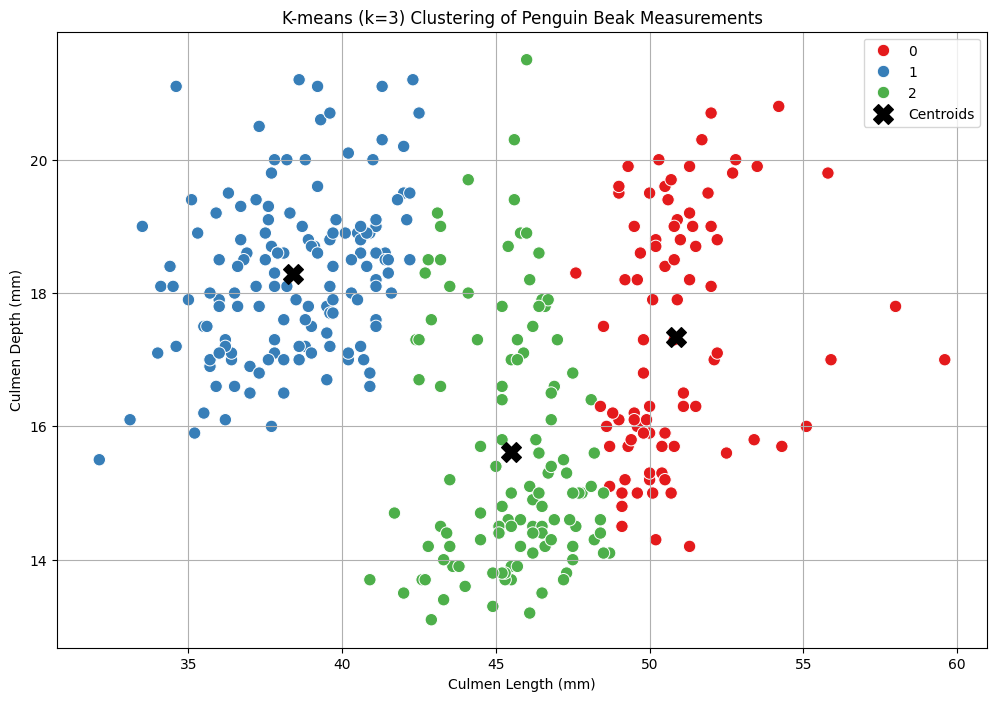

25/05/17 17:27:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 990911 ms exceeds timeout 120000 ms
25/05/17 17:27:32 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/17 17:45:38 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [26]:
# Assemble feature vector
assembler = VectorAssembler(inputCols=["culmen_length_mm", "culmen_depth_mm"], outputCol="features")
penguins_features = assembler.transform(df_clean)

# KMeans with k=3
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="prediction")
model = kmeans.fit(penguins_features)
predictions = model.transform(penguins_features)

# Get centroids
centroids = model.clusterCenters()
print("\nCluster centroids:")
for idx, center in enumerate(centroids):
	print(f"Cluster {idx}: {center}")

# Silhouette score
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(predictions)
print(f"\nSilhouette coefficient: {silhouette:.4f}")

# Convert to Pandas for plotting
pandas_df = predictions.select("culmen_length_mm", "culmen_depth_mm", "prediction").toPandas()

# Plotting clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
	x="culmen_length_mm", 
	y="culmen_depth_mm", 
	hue="prediction", 
	palette="Set1", 
	data=pandas_df, 
	s=80
)
centers_np = np.array(centroids)
plt.scatter(centers_np[:, 0], centers_np[:, 1], c='black', s=200, marker='X', label='Centroids')
plt.title("K-means (k=3) Clustering of Penguin Beak Measurements")
plt.xlabel("Culmen Length (mm)")
plt.ylabel("Culmen Depth (mm)")
plt.legend()
plt.grid(True)
plt.show()

The Silhouette coefficient obtained (**0.6711**) indicates that the clustering with k=3 is very satisfactory. The separation between the clusters is pretty clear (even though its borders may not be very clear in some areas) and the internal cohesion is high. This means that, from the two beak variables (culmen_length_mm and culmen_depth_mm), 3 distinct groups of penguins with similar characteristics can be identified. This indicates that this might correspond to the 3 known species from the original data set file (Adelie, Chinstrap, Gentoo).